## 数据爬取

In [1]:
# 爬取豆瓣《经济学原理》的所有评论
import requests
import lxml
import scrapy
import pandas as pd
import selenium
import numpy as np
from urllib import request,parse
from bs4 import BeautifulSoup
import time
import random

In [54]:
ua_list = [
		"Mozilla/5.0 (X11; U; Linux; hu-HU) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change: 388 835b3b6)",
	    "Mozilla/5.0 (X11; U; Linux; hu-HU) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4",
		"Mozilla/5.0 (X11; U; Linux; cs-CZ) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change: 333 41e3bc6)",
		"Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US) AppleWebKit/527+ (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change:  )",
         'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; Acoo Browser 1.98.744; .NET CLR 3.5.30729)',
        'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; SV1; Acoo Browser; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; Avant Browser)',
        'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; Acoo Browser; SLCC1;   .NET CLR 2.0.50727; Media Center PC 5.0; .NET CLR 3.0.04506)',
        'Mozilla/5.0 (Macintosh; U; Intel Mac OS X Mach-O; en; rv:1.8.1.12) Gecko/20080206 Camino/1.5.5',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36 OPR/26.0.1656.60',
]

In [61]:
def get_comments(book_ids):
    '''
    input: book_ids: list of book ids
    output: comments: list of comments
    '''
    comments = []
    for book_id in book_ids:
        start = 0
        while True:
            url = f'https://book.douban.com/subject/{book_id}/comments/?start={start}&limit=20&status=P&sort=score'
            headers = {'User-Agent': random.choice(ua_list)}
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'lxml')

            comment_items = soup.find_all('li', class_='comment-item')
            if not comment_items:
                break

            for item in comment_items:
                comment_info = {}
                comment_info['type'] = '短评'
                comment_info['book_id'] = book_id
                comment_info['user'] = item.find('a', href=True)['title']
                comment_info['time'] = item.find('a', class_='comment-time').string.strip()
                rating_element = item.find('span', class_=lambda x: x and 'user-stars' in x.split())
                if rating_element is not None:
                    comment_info['rating'] = int(rating_element.get('class')[1][7:]) // 10
                else:
                    comment_info['rating'] = 0 
                comment_info['content'] = item.find('span', class_='short').string
                comments.append(comment_info)

            start += 20
            time.sleep(random.randint(1, 3))  # 避免过于频繁的请求

    return comments

In [14]:
data = """
经济学原理（上下）	机械工业出版社	梁小民	1028842
经济学原理（第8版）-微观经济学分册	北京大学出版社	梁小民	35005103
经济学原理(第7版)	北京大学出版社	梁小民	26435630
经济学原理	北京大学出版社	梁小民	3719533
经济学原理(第8版) - 宏观经济学分册	北京大学出版社	梁小民	35005113
经济学原理 - 宏观经济学分册	北京大学出版社	梁小民	3719531
经济学原理（第7版）- 微观经济学分册	北京大学出版社	梁小民	26388289
经济学原理（第7版）- 宏观经济学分册	北京大学出版社	梁小民	26388291
经济学原理:微观经济学分册(第6版)	北京大学出版社	梁小民	11530078
经济学原理	清华大学出版社	梁小民	1856927
经济学原理（第7版）（典藏版）	北京大学出版社	梁小民	27163861
经济学原理（上下）	北京大学出版社	梁小民	1082175
经济学基础	北京大学出版社	梁小民	4312139
经济学原理 - 宏观经济学分册（第6版）	北京大学出版社	梁小民	11530079
经济学原理（第4版）- 宏观经济学分册			1877969
经济学原理（原书第3版・精装版）	机械工业出版社		1138061
"""

data_list = [line.split('\t') for line in data.split('\n') if line]
df = pd.DataFrame(data_list, columns=["book name", "editor", "translation", "bookid"])

In [15]:
book_ids = df['bookid'].tolist()
comments = get_comments(book_ids)

comments_df = pd.DataFrame(comments)
comments_df.to_csv("comments.csv", index=False)

comments_df1 = comments_df.merge(df[['bookid', 'book name']], how='left', left_on='book_id', right_on='bookid')
comments_df1 = comments_df1.drop(columns=['bookid'])
comments_df1.to_csv("comments_with_name.csv", index=False)

In [16]:
comments_df

,type,book_id,user,time,rating,content
0,短评,1028842,传奇☂,2011-11-21 16:42:13,5,2011-9-15 如果所有的教课书都是这样的，那么我们会有多么幸福！
1,短评,1028842,Ying,2012-09-03 17:42:46,5,为了演讲又翻出来看了下，真是经济学入门最好最有趣的书，没有之一。
2,短评,1028842,角质紧猫,2009-08-29 16:14:39,4,咿呀......知道是本好书可是看不进去怎办呀掩面
3,短评,1028842,leoglory,2010-07-01 08:33:37,5,我以后也要写这样的教科书。
4,短评,1028842,leo,2010-04-11 07:07:13,0,作为一本初级的西方经济学教科书，它十分成功。对于绝大多数渴望了解西方经济学的非专业人员，读完...
...,...,...,...,...,...,...
2925,短评,1138061,雨晴/笑天,2009-05-25 16:23:36,0,曼昆 经济学原理
2926,短评,1138061,豆豆,2011-12-05 12:55:01,5,我的启蒙书（1）
2927,短评,1138061,白茶真好喝,2011-09-07 13:27:05,5,经济学的入门书籍，内容浅显易懂，生动有趣，很适合想了解经济学的初学者
2928,短评,1138061,止于至善,2013-04-08 22:18:51,5,内容全面，文字通俗易懂，非常适合经济学入门的一本书!


In [17]:
comments_df1

,type,book_id,user,time,rating,content,book name
0,短评,1028842,传奇☂,2011-11-21 16:42:13,5,2011-9-15 如果所有的教课书都是这样的，那么我们会有多么幸福！,经济学原理（上下）
1,短评,1028842,Ying,2012-09-03 17:42:46,5,为了演讲又翻出来看了下，真是经济学入门最好最有趣的书，没有之一。,经济学原理（上下）
2,短评,1028842,角质紧猫,2009-08-29 16:14:39,4,咿呀......知道是本好书可是看不进去怎办呀掩面,经济学原理（上下）
3,短评,1028842,leoglory,2010-07-01 08:33:37,5,我以后也要写这样的教科书。,经济学原理（上下）
4,短评,1028842,leo,2010-04-11 07:07:13,0,作为一本初级的西方经济学教科书，它十分成功。对于绝大多数渴望了解西方经济学的非专业人员，读完...,经济学原理（上下）
...,...,...,...,...,...,...,...
2925,短评,1138061,雨晴/笑天,2009-05-25 16:23:36,0,曼昆 经济学原理,经济学原理（原书第3版・精装版）
2926,短评,1138061,豆豆,2011-12-05 12:55:01,5,我的启蒙书（1）,经济学原理（原书第3版・精装版）
2927,短评,1138061,白茶真好喝,2011-09-07 13:27:05,5,经济学的入门书籍，内容浅显易懂，生动有趣，很适合想了解经济学的初学者,经济学原理（原书第3版・精装版）
2928,短评,1138061,止于至善,2013-04-08 22:18:51,5,内容全面，文字通俗易懂，非常适合经济学入门的一本书!,经济学原理（原书第3版・精装版）


In [18]:
pd.value_counts(comments_df1['rating']) # 统计评分

5    1971
4     528
0     289
3     115
1      14
2      13
Name: rating, dtype: int64

In [22]:
# 根据rating创建sentiment列
def label_sentiment(row):
    if row['rating'] <= 0:
        return None  #返回空值
    elif row['rating'] == 1 or row['rating'] == 2:  # negative
        return -1
    elif row['rating'] == 3:   # neutral
        return 0
    else:
        return 1   # positive

comments_df1['sentiment'] = comments_df1.apply(label_sentiment, axis=1)

In [24]:
pd.value_counts(comments_df1['sentiment'])

 1.0    2499
 0.0     115
-1.0      27
Name: sentiment, dtype: int64

In [25]:
comments_df1.to_csv("comments_with_name.csv", index=False)

## 数据预处理

In [2]:
import numpy as np
import re 
import jieba # 中文分词
import os 
import matplotlib.pyplot as plt #
%matplotlib inline
import tensorflow as tf  
from tensorflow import keras

d:\python\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# 读取爬好的数据
comments = pd.read_csv("comments_with_name.csv")

In [4]:
comments.head()

,type,book_id,user,time,rating,content,book name,sentiment
0,短评,1028842,传奇☂,2011-11-21 16:42:13,5,2011-9-15 如果所有的教课书都是这样的，那么我们会有多么幸福！,经济学原理（上下）,1.0
1,短评,1028842,Ying,2012-09-03 17:42:46,5,为了演讲又翻出来看了下，真是经济学入门最好最有趣的书，没有之一。,经济学原理（上下）,1.0
2,短评,1028842,角质紧猫,2009-08-29 16:14:39,4,咿呀......知道是本好书可是看不进去怎办呀掩面,经济学原理（上下）,1.0
3,短评,1028842,leoglory,2010-07-01 08:33:37,5,我以后也要写这样的教科书。,经济学原理（上下）,1.0
4,短评,1028842,leo,2010-04-11 07:07:13,0,作为一本初级的西方经济学教科书，它十分成功。对于绝大多数渴望了解西方经济学的非专业人员，读完...,经济学原理（上下）,NaN


In [18]:
train = comments[(comments['sentiment'] == 1) | (comments['sentiment'] == -1)]
train_content = train['content'].tolist()
train_sentiment = train['sentiment'].tolist()

word_dic = set() # 分词总长度
for text in train_content:
    text=str(text)
    text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……·]+", "", text)
    # 分词 tokenization
    cut = jieba.lcut(text)
    for word in cut:
        word_dic.add(word)

In [25]:
len(word_dic)

7290

#### words to one-hot vector

In [26]:
# 为每一个词创建一个向量，这里用词典表示
word2v= dict()
for i, word in enumerate(word_dic):
    word2v[word] = i

# 为每个comment创建对应向量
train_comment_all = []
for text in train_content:
    text=str(text)
    text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……·]+", "", text)
    
    data = list()
    cut = jieba.lcut(text)
    for word in cut:
        index = word2v[word]
        data.append(index)
    train_comment_all.append(data)

In [27]:
word2v

{'有没有': 0,
 '不考': 1,
 '辩论': 2,
 '学可': 3,
 '能': 4,
 '归功于': 5,
 '帖子': 6,
 '与时俱进': 7,
 '稀缺资源': 8,
 '想想': 9,
 '人格': 10,
 '艰苦': 11,
 '砖头': 12,
 '一个月': 13,
 '角力': 14,
 '硕士': 15,
 '理直气壮': 16,
 '接着': 17,
 '架构': 18,
 '多以': 19,
 '两章': 20,
 '04210429': 21,
 '通史': 22,
 '太贵': 23,
 '出神入化': 24,
 '厚': 25,
 'tradeoff': 26,
 '塞缪尔': 27,
 '脑壳': 28,
 'tt': 29,
 '恐怕': 30,
 '管控': 31,
 '第三次': 32,
 '合在一起': 33,
 '联系': 34,
 '可怜虫': 35,
 '1119FinallyfinishedreadingRememberRefertomynotebookTheresareallyelaboratenotenoexaggeration': 36,
 'kindle': 37,
 '反映': 38,
 '译笔': 39,
 '那门': 40,
 '全彩': 41,
 '猜': 42,
 '中文网': 43,
 '现实生活': 44,
 'good': 45,
 '男人': 46,
 '工程系': 47,
 '這句': 48,
 '美联储': 49,
 '赶着': 50,
 '下定决心': 51,
 '一窍不通': 52,
 '大补': 53,
 '期限': 54,
 '唯': 55,
 '通向': 56,
 '必修课': 57,
 '学来': 58,
 '难点': 59,
 '〖': 60,
 '及其': 61,
 '淡化': 62,
 '笃定': 63,
 '在读': 64,
 '旅游': 65,
 '看穿': 66,
 '大一上': 67,
 '终究': 68,
 '非专业': 69,
 '释义': 70,
 '崇拜': 71,
 '失望': 72,
 '群体': 73,
 '年少': 74,
 '说书': 75,
 '转投': 76,
 '妥协': 77,
 '清华': 78,
 '广州': 79,


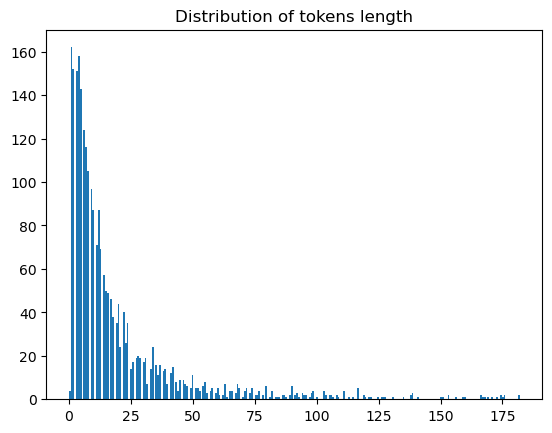

In [39]:
len_token=[len(comment) for comment in train_comment_all]
plt.hist(len_token, bins=250)
plt.title('Distribution of tokens length')
plt.show()

In [40]:
import statistics
statistics.median(len_token)

10.0

In [41]:
train_comment_all = keras.preprocessing.sequence.pad_sequences(
    train_comment_all,
    value=0,
    padding='post',
    maxlen=75 #截取75 作为一致长度
)

## SA


In [44]:
# tf包 创建数据集
train_ds = tf.data.Dataset.from_tensor_slices((train_comment_all, train_sentiment)).shuffle(20000).batch(32)

# LSTM model set 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_dic), 64), # embedding by using word_dic which lenth is around 2000
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # bi-direction such that info will be dealt with two direction
    tf.keras.layers.Dense(64, activation='relu'),  # 隐藏层 activation function is relu
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer
])

In [45]:
# training process
# loss function = 二元交叉熵下降
# optimizers is Adam https://blog.51cto.com/u_15429890/4643873

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

history = model.fit(train_ds, epochs=10) # 10 times

Epoch 1/10


C:\Users\Matebook\AppData\Roaming\Python\Python38\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


79/79 [==============================] - 6s 36ms/step - loss: 0.5723 - accuracy: 0.9584
Epoch 2/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1245 - accuracy: 0.9893
Epoch 3/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1065 - accuracy: 0.9893
Epoch 4/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1058 - accuracy: 0.9893
Epoch 5/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1053 - accuracy: 0.9893
Epoch 6/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1043 - accuracy: 0.9893
Epoch 7/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1048 - accuracy: 0.9893
Epoch 8/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1038 - accuracy: 0.9893
Epoch 9/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1037 - accuracy: 0.9893
Epoch 10/10
79/79 [==============================] - 3s 37ms/step - loss: 0.1036 - accuracy: 0.9893


## 模型效果

In [47]:
def convert_to_model_input(text):
    text=str(text)
    text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·]+", "", text)
    cut = jieba.lcut(text)
    cut_list = []
    for word in cut:
        if word in word2v:
            index = word2v[word]
            cut_list.append(index)

    if not cut_list:
        return None

    tokens_pad = keras.preprocessing.sequence.pad_sequences(
        [cut_list],
        value=0,
        padding='post', 
        maxlen=75)

    return tokens_pad

comments['model_input'] = comments['content'].apply(convert_to_model_input)

# 删除model_input为None的行
comments = comments.dropna(subset=['model_input'])

predictions = model.predict(np.vstack(comments['model_input'].values))

comments['modelpredict'] = predictions

91/91 [==============================] - 2s 11ms/step


In [49]:
comments
selected_comments = comments[(comments['sentiment'].isnull()) | (comments['sentiment'] == 0)]

In [50]:
selected_comments

,type,book_id,user,time,rating,content,book name,sentiment,model_input,modelpredict
4,短评,1028842,leo,2010-04-11 07:07:13,0,作为一本初级的西方经济学教科书，它十分成功。对于绝大多数渴望了解西方经济学的非专业人员，读完...,经济学原理（上下）,NaN,"[[1026, 4923, 4220, 6134, 5149, 5797, 6624, 72...",0.982805
6,短评,1028842,Once,2013-09-04 20:18:14,0,比《经济学的思维方式》更好一些,经济学原理（上下）,NaN,"[[4093, 1750, 5797, 6134, 6900, 1206, 3158, 65...",0.983077
11,短评,1028842,[已注销],2010-08-02 20:14:24,0,只看完了上册。。。下册过阵子再看吧。。蛋疼,经济学原理（上下）,NaN,"[[4064, 596, 671, 6116, 4095, 6416, 3797, 1056...",0.982113
13,短评,1028842,withinbeyond,2010-09-21 22:54:31,3,逻辑没有问题，有问题的是作为起点的假设。,经济学原理（上下）,0.0,"[[3228, 175, 995, 2788, 995, 6134, 2002, 1026,...",0.982413
25,短评,1028842,Miss power,2009-08-22 03:00:32,0,简单，但清晰。入门级读物~,经济学原理（上下）,NaN,"[[905, 5773, 5118, 4118, 6591, 0, 0, 0, 0, 0, ...",0.982407
...,...,...,...,...,...,...,...,...,...,...
2907,短评,1138061,风依,2011-09-03 13:39:06,0,"深入浅出, 生动的经济教科书",经济学原理（原书第3版・精装版）,NaN,"[[2648, 3634, 6134, 4648, 6624, 0, 0, 0, 0, 0,...",0.982927
2912,短评,1138061,夏鱼,2005-07-07 18:21:24,3,大学的教材,经济学原理（原书第3版・精装版）,0.0,"[[3007, 6134, 1246, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.982505
2917,短评,1138061,土成,2006-02-28 15:09:04,0,呵，想起了大学,经济学原理（原书第3版・精装版）,NaN,"[[2923, 4094, 6116, 3007, 0, 0, 0, 0, 0, 0, 0,...",0.982179
2923,短评,1138061,寂天神秀,2006-05-29 18:38:49,0,当今三大流行经济学教科书之一,经济学原理（原书第3版・精装版）,NaN,"[[6278, 3201, 5797, 6624, 3534, 0, 0, 0, 0, 0,...",0.982170


## 爬取中信出版社下所有书本的短评

In [3]:
# 爬取豆瓣《经济学原理》的所有评论
import requests
import lxml
import scrapy
import pandas as pd
import selenium
import numpy as np
from urllib import request,parse
from bs4 import BeautifulSoup
import time
import random
import numpy as np
import re 
import jieba # 中文分词
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf  
from tensorflow import keras
from sklearn.model_selection import train_test_split

d:\python\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
ua_list = [
		"Mozilla/5.0 (X11; U; Linux; hu-HU) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change: 388 835b3b6)",
	    "Mozilla/5.0 (X11; U; Linux; hu-HU) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4",
		"Mozilla/5.0 (X11; U; Linux; cs-CZ) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change: 333 41e3bc6)",
		"Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US) AppleWebKit/527+ (KHTML, like Gecko, Safari/419.3)  Arora/0.4 (Change:  )",
         'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; Acoo Browser 1.98.744; .NET CLR 3.5.30729)',
        'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; SV1; Acoo Browser; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; Avant Browser)',
        'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; Acoo Browser; SLCC1;   .NET CLR 2.0.50727; Media Center PC 5.0; .NET CLR 3.0.04506)',
        'Mozilla/5.0 (Macintosh; U; Intel Mac OS X Mach-O; en; rv:1.8.1.12) Gecko/20080206 Camino/1.5.5',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36 OPR/26.0.1656.60',
]

In [5]:
def get_comments(book_ids):
    '''
    input: book_ids: list of book ids
    output: comments: list of comments
    '''
    comments = []
    for book_id in book_ids:
        start = 0
        while True:
            url = f'https://book.douban.com/subject/{book_id}/comments/?start={start}&limit=20&status=P&sort=score'
            headers = {'User-Agent': random.choice(ua_list)}
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'lxml')

            comment_items = soup.find_all('li', class_='comment-item')
            if not comment_items:
                break

            for item in comment_items:
                comment_info = {}
                comment_info['type'] = '短评'
                comment_info['book_id'] = book_id
                comment_info['user'] = item.find('a', href=True)['title']
                comment_info['time'] = item.find('a', class_='comment-time').string.strip()
                rating_element = item.find('span', class_=lambda x: x and 'user-stars' in x.split())
                if rating_element is not None:
                    comment_info['rating'] = int(rating_element.get('class')[1][7:]) // 10
                else:
                    comment_info['rating'] = 0 
                comment_info['content'] = item.find('span', class_='short').string
                comments.append(comment_info)

            start += 20
            time.sleep(random.randint(2, 5))  # 避免过于频繁的请求
    if comments==[]:
        print('错误：没有找到该书籍的评论！')
    return comments

In [6]:
def get_press_book(press_ids,end=20):
    '''
    input: press_ids: list of press ids 出版社id list
    output: books: list of books 书籍信息list
    '''
    books = []
    for press_id in press_ids:
        page = 1
        while page <= end:
            url = f'https://book.douban.com/press/{press_id}/?page={page}'
            headers = {'User-Agent': random.choice(ua_list)}
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'lxml')

            subjects_items = soup.find_all('li', class_='subject-item')
            if not subjects_items:
                break

            for item in subjects_items:
                book = {}
                book['bookid'] = item.find('a', class_='nbg')['href'].split('/')[-2]
                book['book name'] = item.find('a', title=True)['title']
                book['info'] = item.find('div', class_='pub').get_text(strip=True)
                books.append(book)

            page += 1
            # 如果页数大于20，停止

            time.sleep(random.randint(4, 6))  # 避免过于频繁的请求
    if books==[]:
        print('错误')
    return books

In [17]:
books=get_press_book(['2908'],end=10)  # 中信出版社的编号
books_df=pd.DataFrame(books)
books_df

,bookid,book name,info
0,35295592,小狗钱钱,[德] 博多·舍费尔 / 文燚 / 中信出版集团 / 2021-2 / 39.80元
1,30443973,想象一朵未来的玫瑰,[葡] 费尔南多·佩索阿 / 杨铁军 / 中信出版集团 / 2019-5 / 59.80
2,35173329,真希望我父母读过这本书,[英] 菲利帕·佩里 / 洪慧芳 / 中信出版集团 / 2020-8-18 / 48.00元
3,34835320,这里是中国,星球研究所、中国青藏高原研究会 / 中信出版集团 / 2019-9 / 168.00元
4,35059158,女孩之城,[美]伊丽莎白·吉尔伯特 / 姜小瑁 / 中信出版集团 / 2020-6 / 59.00
...,...,...,...
95,35813664,宇宙重建了自身,[葡萄牙] 费尔南多·佩索阿 / 程一身 / 中信出版集团 / 2022-5 / 58.00
96,33395248,掉队的拉美,[智]塞巴斯蒂安.爱德华兹 / 郭金兴 / 中信出版集团 / 2019-6 / 68
97,34918511,风雨琳琅,陈新华 / 中信出版集团 / 2020-1 / 98
98,36158449,上京,李唐 / 中信出版集团 / 2023-1 / 56.00


In [18]:
book_ids=books_df['bookid'].tolist()
len(book_ids)

In [7]:
# 根据rating创建sentiment列
def label_sentiment(row):
    if row['rating'] <= 0:
        return None  #返回空值
    elif row['rating'] == 1:
        return -1
    elif row['rating'] == 2:
        return -0.5
    elif row['rating'] == 3:   # neutral
        return 0
    elif row['rating'] == 4:
        return 0.5
    else:
        return 1   # positive

In [8]:
def pre_processing(comments):
    '''
    input: dataframe
    output: train_comment_all, train_sentiment, word2v ,word_dic
    '''
    
    # 生成sentiment列
    comments['sentiment'] = comments.apply(label_sentiment, axis=1)

    # 生成训练集
    # sentiment为空值的行，不要
    train = comments.dropna(subset=['sentiment'])
    print('原样本量：'+ str(len(comments)))
    print('去掉无评分后，剩余样本量：' + str(len(train)))
    train_content = train['content'].tolist()
    train_sentiment = train['sentiment'].tolist()

    # 生成词典
    word_dic = set() # 分词总长度
    for text in train_content:
        text=str(text)
        text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……·]+", "", text)
        # 分词 tokenization
        cut = jieba.lcut(text)
        for word in cut:
            word_dic.add(word)
    print('词典长度：',len(word_dic))

    # 为每一个词创建一个向量，这里用词典表示
    word2v= dict()
    for i, word in enumerate(word_dic):
        word2v[word] = i

    # 为每个comment创建对应向量
    train_comment_all = []
    for text in train_content:
        text=str(text)
        text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……·]+", "", text)

        data = list()
        cut = jieba.lcut(text)
        for word in cut:
            index = word2v[word]
            data.append(index)
        train_comment_all.append(data)

    # 画图
    len_token=[len(comment) for comment in train_comment_all]
    plt.hist(len_token, bins=250)
    plt.title('Distribution of tokens length')
    plt.show()

    return train_comment_all, train_sentiment, word2v ,word_dic


In [9]:
def sa_process(maxlen, train_comment_all, train_sentiment, word2v ,word_dic):
    # 截取长度
    train_comment_all = keras.preprocessing.sequence.pad_sequences(
    train_comment_all,
    value=0,
    padding='post',
    maxlen=maxlen 
    )

    # tf包 创建数据集
    # 
    train_ds = tf.data.Dataset.from_tensor_slices((train_comment_all, train_sentiment)).shuffle(20000).batch(32)

    # LSTM model set 
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(word_dic), 64), # embedding by using word_dic which lenth is around 2000
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # bi-direction such that info will be dealt with two direction
        tf.keras.layers.Dense(64, activation='relu'),  # 隐藏层 activation function is relu
        tf.keras.layers.Dense(1, activation='sigmoid') # output layer
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

    history = model.fit(train_ds, epochs=10) # 10 times

    return model


In [22]:
# 爬取的示例：从中断点继续
#comments = pd.DataFrame()
#for i in range(81, len(book_ids)):
#    comments_batch = get_comments([book_ids[i]])
#    print(f'第{i+1}本爬取完成')
#    comments = pd.concat([comments, pd.DataFrame(comments_batch)], ignore_index=True)
#    time.sleep(random.randint(3,7))  # 避免过于频繁的请求

第82本爬取完成
第83本爬取完成
第84本爬取完成
第85本爬取完成
第86本爬取完成
第87本爬取完成
第88本爬取完成
第89本爬取完成
第90本爬取完成
第91本爬取完成
第92本爬取完成
第93本爬取完成
第94本爬取完成
第95本爬取完成
第96本爬取完成
第97本爬取完成
第98本爬取完成
第99本爬取完成
第100本爬取完成


In [10]:
# 读取已经爬好的数据
import pandas as pd
comments1 = pd.read_csv("comments_1_press.csv")
comments2 = pd.read_csv("comments_2_press.csv")
comments = pd.concat([comments1, comments2], ignore_index=True)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Matebook\AppData\Local\Temp\jieba.cache


原样本量：17263
去掉无评分后，剩余样本量：16399


Loading model cost 1.202 seconds.
Prefix dict has been built successfully.


词典长度： 44751


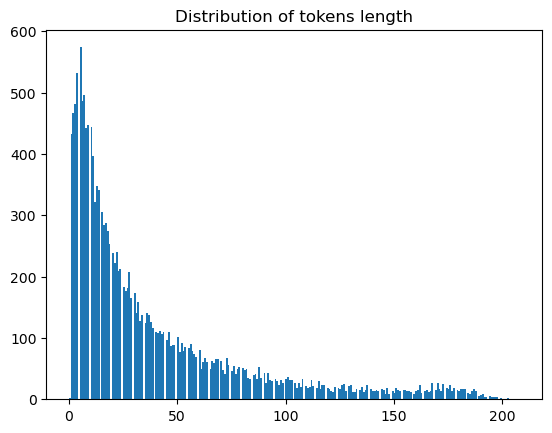

In [14]:
train_comment_all, train_sentiment, word2v ,word_dic = pre_processing(comments)

In [15]:
len(train_comment_all)

16399

In [16]:
model = sa_process(100, train_comment_all, train_sentiment, word2v ,word_dic)

Epoch 1/10


C:\Users\Matebook\AppData\Roaming\Python\Python38\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


513/513 [==============================] - 41s 67ms/step - loss: 0.6867 - accuracy: 0.3232
Epoch 2/10
513/513 [==============================] - 36s 70ms/step - loss: 0.6009 - accuracy: 0.4124
Epoch 3/10
513/513 [==============================] - 35s 69ms/step - loss: 0.4981 - accuracy: 0.4577
Epoch 4/10
513/513 [==============================] - 36s 70ms/step - loss: 0.3772 - accuracy: 0.4803
Epoch 5/10
513/513 [==============================] - 36s 70ms/step - loss: 0.2047 - accuracy: 0.4886
Epoch 6/10
513/513 [==============================] - 38s 75ms/step - loss: -0.0322 - accuracy: 0.4881
Epoch 7/10
513/513 [==============================] - 36s 71ms/step - loss: -0.2453 - accuracy: 0.4964
Epoch 8/10
513/513 [==============================] - 35s 69ms/step - loss: -0.6880 - accuracy: 0.4971
Epoch 9/10
513/513 [==============================] - 37s 72ms/step - loss: -0.4410 - accuracy: 0.4860
Epoch 10/10
513/513 [==============================] - 35s 68ms/step - loss: -1.3753 - ac

### 测试

In [43]:
def convert_to_model_input(text):
    text=str(text)
    text = re.sub("[\r|\n|\\s!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·]+", "", text)
    cut = jieba.lcut(text)
    cut_list = []
    for word in cut:
        if word in word2v:
            index = word2v[word]
            cut_list.append(index)

    if not cut_list:
        return None

    tokens_pad = keras.preprocessing.sequence.pad_sequences(
        [cut_list],
        value=0,
        padding='post', 
        maxlen=100)

    return tokens_pad

In [ ]:
test_comments = comments[comments['rating']==0] # 保留无评分的部分
test_comments['model_input'] = test_comments['content'].apply(convert_to_model_input)
test_comments = test_comments.dropna(subset=['model_input'])

In [41]:
test_comments['prediction'] = test_comments['model_input'].apply(lambda x: model.predict(x,verbose=0) if pd.notna(x).all() else None)


C:\Users\Matebook\AppData\Local\Temp\ipykernel_12904\1037392810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_comments['prediction'] = test_comments['model_input'].apply(lambda x: model.predict(x,verbose=0) if pd.notna(x).all() else None)


In [42]:
test_comments

,type,book_id,user,time,rating,content,sentiment,model_input,prediction
11,短评,35295592,小梅森塔尔,2021-03-02 17:29:16,0,之前看过《富爸爸穷爸爸》，那时候可能还不懂，没什么太大感触。这本还颇有启发,NaN,"[[30061, 32441, 20966, 18210, 27607, 2906, 311...",[[3.7318362e-26]]
43,短评,35295592,安多,2021-04-09 02:37:43,0,夸夸自己就能挣钱,NaN,"[[5585, 2101, 1205, 30373, 42612, 0, 0, 0, 0, ...",[[0.0025591285]]
74,短评,35295592,k,2022-03-28 18:32:09,0,3.28.2022 在家读完 历时两天 便于阅读 读这本书的速度于我而言很快 肯定是翻译水平...,NaN,"[[17694, 23669, 785, 5375, 10855, 23728, 8594,...",[[0.9961475]]
116,短评,35295592,原小宁,2022-03-10 23:01:46,0,我没有童心了竟然这样的童话故事都不喜欢。,NaN,"[[10472, 21008, 15643, 43017, 16959, 17683, 41...",[[0.014435642]]
124,短评,35295592,Spring Mel,2022-02-13 00:53:42,0,又是一本二十年前的书，明确目标场景 做目标相册 成功日记 理财 小狗钱钱对你说,NaN,"[[30950, 30847, 30927, 4863, 12047, 41735, 367...",[[0.55336577]]
...,...,...,...,...,...,...,...,...,...
17228,短评,35972519,新思文化,2022-12-09 11:29:11,0,我们如何从无生命的物质变成一个有生命的人？“有关意识的神经科学的最佳图书”！,NaN,"[[16740, 5440, 1945, 10034, 11408, 41735, 2668...",[[0.9850611]]
17245,短评,35972519,0.8s,2023-05-15 17:11:26,0,（沮丧,NaN,"[[41723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[[0.5670902]]
17246,短评,35972519,Yun,2023-08-27 18:37:17,0,好难捏。看了50页遂选择放弃，不过启发了对于意识的思考，意识这个抽象的话题充满奥秘，需要具备...,NaN,"[[4280, 34394, 17069, 43017, 30226, 22749, 434...",[[0.8670391]]
17253,短评,35972519,一只野怪,2023-08-02 18:18:20,0,我的意识不足以支撑我把这本书读完,NaN,"[[10472, 41735, 12985, 29800, 30317, 10472, 17...",[[0.031450834]]


In [28]:

print(model.predict(convert_to_model_input('不知道作者在想什么，这种东西也写得出来，误人子弟')))
print(model.predict(convert_to_model_input('收藏了一整套，很喜欢')))
print(model.predict(convert_to_model_input('一般般吧，不是很喜欢')))
print(model.predict(convert_to_model_input('这本书太差劲了')))
print(model.predict(convert_to_model_input('一口气读完，非常喜欢')))
print(model.predict(convert_to_model_input('还不错，但是翻译一般')))

1/1 [==============================] - 0s 41ms/step
[[9.938902e-09]]
1/1 [==============================] - 0s 34ms/step
[[0.38394192]]
1/1 [==============================] - 0s 35ms/step
[[0.0142372]]
1/1 [==============================] - 0s 33ms/step
[[0.00103385]]
1/1 [==============================] - 0s 36ms/step
[[0.99219805]]
1/1 [==============================] - 0s 37ms/step
[[1.9897152e-05]]
